## Drug Molecule Generation with VAE

**Author:** [Victor Basu](https://www.linkedin.com/in/victor-basu-520958147)<br>
**Date created:** 2022/03/10<br>
**Last modified:** 2022/03/27<br>
**Description:** Implementing a Convolutional Variational AutoEncoder (VAE) for Drug Discovery.

## Note

This notebook is an experimental version of the original example that I have contributed at Keras.io, [Drug Molecule Generation with VAE](https://keras.io/examples/generative/molecule_generation/). Please visit the original example mentioned for understanding.

## Introduction
In this example, we use a Variational Autoencoder to generate molecules for drug discovery.
We use the research papers
[Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415)
and [MolGAN: An implicit generative model for small molecular graphs](https://arxiv.org/abs/1805.11973)
as a reference.
The model described in the paper **Automatic chemical design using a data-driven
continuous representation of molecules** generates new molecules via efficient exploration
of open-ended spaces of chemical compounds. The model consists of
three components: Encoder, Decoder and Predictor. The Encoder converts the discrete
representation of a molecule into a real-valued continuous vector, and the Decoder
converts these continuous vectors back to discrete molecule representations. The
Predictor estimates chemical properties from the latent continuous vector representation
of the molecule. Continuous representations allow the use of gradient-based
optimization to efficiently guide the search for optimized functional compounds.
![intro](https://bit.ly/3CtPMzM)
**Figure (a)** - A diagram of the autoencoder used for molecule design, including the
joint property prediction model. Starting from a discrete molecule representation, such
as a SMILES string, the encoder network converts each molecule into a vector in the
latent space, which is effectively a continuous molecule representation. Given a point
in the latent space, the decoder network produces a corresponding SMILES string. A
multilayer perceptron network estimates the value of target properties associated with
each molecule.
**Figure (b)** - Gradient-based optimization in continuous latent space. After training a
surrogate model `f(z)` to predict the properties of molecules based on their latent
representation `z`, we can optimize `f(z)` with respect to `z` to find new latent
representations expected to match specific desired properties. These new latent
representations can then be decoded into SMILES strings, at which point their properties
can be tested empirically.
For an explanation and implementation of MolGAN, please refer to the Keras Example
[**WGAN-GP with R-GCN for the generation of small molecular graphs**](https://bit.ly/3pU6zXK) by
Alexander Kensert. Many of the functions used in the present example are from the above Keras example.

## Setup
RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conviently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.
Quoting from
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/)):
**"SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features."**

In [1]:
!pip -q install rdkit-pypi

In [2]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

## Dataset

We use the [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://bit.ly/3IVBI4x) dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
**logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).

In [3]:
df = pd.read_csv(r"dataset\250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()
df = df[:100].copy()

In [4]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

SMILES:	CCc1ccc(CNC(=O)c2ccc(-c3nccnc3N3CCCCC3)cc2)cc1
logP:	4.6263
qed:	0.6265585492769999
Molecule:


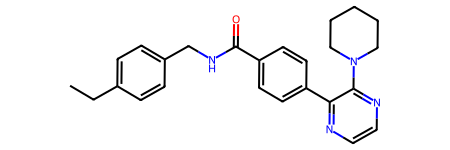

In [5]:
print(f"SMILES:\t{df.smiles[99]}\nlogP:\t{df.logP[99]}\nqed:\t{df.qed[99]}")
molecule = molecule_from_smiles(df.iloc[99].smiles)
print("Molecule:")
molecule

In [6]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'             
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 68
Character set Length: 11


## Hyperparameters

In [7]:
BATCH_SIZE = 32
EPOCHS =10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space

In [8]:
def smiles_to_graph(smiles):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [9]:
a,f = smiles_to_graph(df.iloc[29].smiles)
print("Adjacency matrix:", type(a))

Adjacency matrix: <class 'numpy.ndarray'>


## Build Dataloader

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, mapping, max_len, batch_size=6, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.indices = np.arange(len(self.data))  # Modify to update indices correctly
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation 
        and their respective SAS value.
        """
        qed = self.data.loc[idx]['qed']

        adjacency, features = smiles_to_graph(self.data.loc[idx]['smiles'])

        return adjacency, features, qed
    
    def data_generation(self, batch):
        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size, ))
        
        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)

        return (np.array(x1), np.array(x2)), np.array(x3)



##  Generate training set

In [11]:
train_df = df.sample(frac=0.75,random_state=42) #random state is a seed value
test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [12]:
class RelationalGraphConvLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder
The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.
**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:
`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`
Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.
Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))
The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

In [13]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units,dropout_rate ):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    adjacency = tf.keras.layers.Input(shape=adjacency_shape)
    features = tf.keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = tf.keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    z_mean = tf.keras.layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = tf.keras.layers.Dense(latent_dim, dtype="float32", name="log_var")(x)
    
    encoder = tf.keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

class Symmetrify(tf.keras.layers.Layer):
    def call(self, inputs):
        return (inputs + tf.transpose(inputs, (0, 1, 3, 2))) / 2

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    latent_inputs = tf.keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="tanh")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = tf.keras.layers.Dense(np.prod(adjacency_shape))(x)
    x_adjacency = tf.keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = Symmetrify()(x_adjacency)
    x_adjacency = tf.keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = tf.keras.layers.Dense(np.prod(feature_shape))(x)
    x_features = tf.keras.layers.Reshape(feature_shape)(x_features)
    x_features = tf.keras.layers.Softmax(axis=2)(x_features)

    decoder = tf.keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")

    return decoder

## Build Sampling layer

In [14]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the VAE
This model is trained to optimize four losses:
* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)
The categorical crossentropy loss function measures the model's
reconstruction accuracy. The Property prediction loss estimates the mean squared
error between predicted and actual properties after running the latent representation
through a property prediction model. The property
prediction of the model is optimized via binary crossentropy. The gradient
penalty is further guided by the model's property (SAS) prediction.
A gradient penalty is an alternative soft constraint on the
1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the
original neural network
("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at evey single
point of the function).
It adds a regularization term to the loss function.

In [15]:
class MoleculeGenerator(tf.keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = tf.keras.layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = tf.keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name="val_total_loss")
        # self.train_total_loss_tracker = []
        # self.val_total_loss_tracker = []
    
    def train_step(self, data):
        
        mol_features, mol_property = data
        # print(mol_features, mol_property, data)
        graph_real = mol_features
        self.batch_size = tf.shape(mol_property)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, property_prediction, \
             reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                             training=True)
            graph_generated = [reconstruction_adjacency, reconstruction_features]
            total_loss = self.calculate_loss(z_log_var,
                                             z_mean,
                                             mol_property,
                                             property_prediction,
                                             graph_real,
                                             graph_generated,
                                             is_train=True)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        # self.train_total_loss_tracker.append(total_loss)
        return {
            "train_loss": self.train_total_loss_tracker.result()
        }

    def test_step(self, data):
        mol_features, mol_property = data
        z_mean, z_log_var, property_prediction, \
        reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                training=False)
        total_loss = self.calculate_loss(z_log_var,
                                        z_mean,
                                        mol_property, 
                                        property_prediction,
                                        graph_real=mol_features,
                                        graph_generated=[reconstruction_adjacency, 
                                                        reconstruction_features],
                                        is_train=False)

        self.val_total_loss_tracker.update_state(total_loss)
        # self.val_total_loss_tracker.append(total_loss)
        return {
            "val_loss": self.val_total_loss_tracker.result()
        }

    def calculate_loss(self,
                       z_log_var,
                       z_mean,
                       mol_property,
                       property_prediction,
                       graph_real,
                       graph_generated,
                       is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        
        adjacency_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        adjacency_real,
                                                        adjacency_generated
                                                        ),
                                                        axis=(1,2)
                    )
            )
        features_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        features_real,
                                                        features_generated
                                                        ),
                                                        axis=(1)
                    )
            )
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)
         
    
        property_prediction_loss = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(tf.expand_dims(mol_property, axis = 1), property_prediction)
)
        
    

        if is_train:
            graph_loss = self._gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        adjacency_real = tf.cast(adjacency_real, tf.float32)
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        features_real = tf.cast(features_real, tf.float32)
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _,_ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )
    
    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = self.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]
    
    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_prediction, reconstruction_adjacency, reconstruction_features

## Train the model

In [16]:
train_loader = DataGenerator(
    data=train_df[:8000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:8000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
    )

In [19]:
vae_optimizer = tf.keras.optimizers.Adam(
    learning_rate=VAE_LR
)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)

model = MoleculeGenerator(encoder, 
                          decoder,
                          MAX_MOLSIZE)

model.compile(vae_optimizer)

history = model.fit(train_loader,
                    epochs=5,
                    validation_data=validation_loader)


Epoch 1/5


e:\IITB\SEM8\ME793\Drug Discovery\Drug-Discovery\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - train_loss: 69660.5703 - loss: 0.0000e+00 - train_total_loss: 69604.8750 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69468.4375
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - train_loss: 69440.2578 - loss: 0.0000e+00 - train_total_loss: 69428.4453 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69393.5078
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 841ms/step - train_loss: 69370.6719 - loss: 0.0000e+00 - train_total_loss: 69370.7734 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69378.4688
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 777ms/step - train_loss: 69377.6016 - loss: 0.0000e+00 - train_total_loss: 69379.7500 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69389.5938
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3

In [66]:
plt.plot(history.history['train_loss'])
# plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: 'train_loss'

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


e:\IITB\SEM8\ME793\Drug Discovery\Drug-Discovery\.venv\Lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


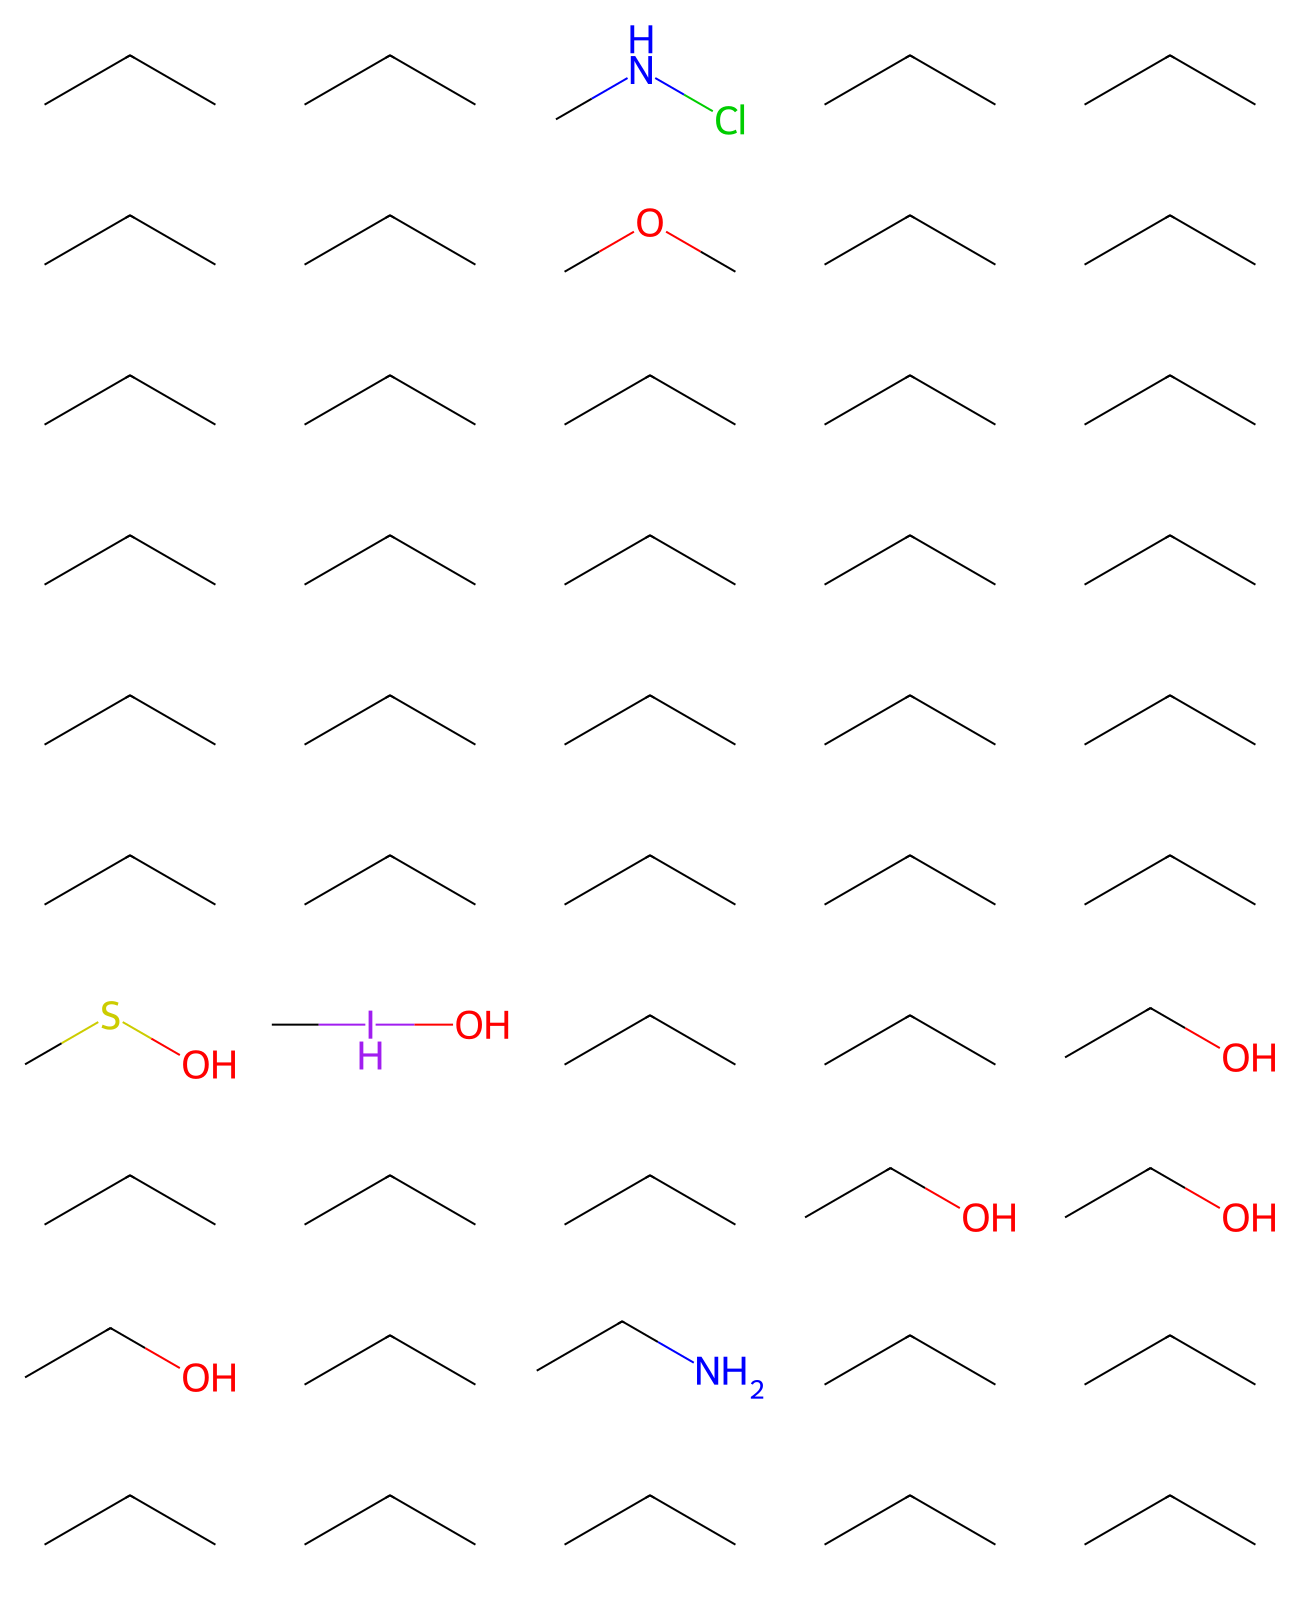

In [60]:
molecules = model.inference(1000)

MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

### Display latent space clusters with respect to molecular properties (SAS)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


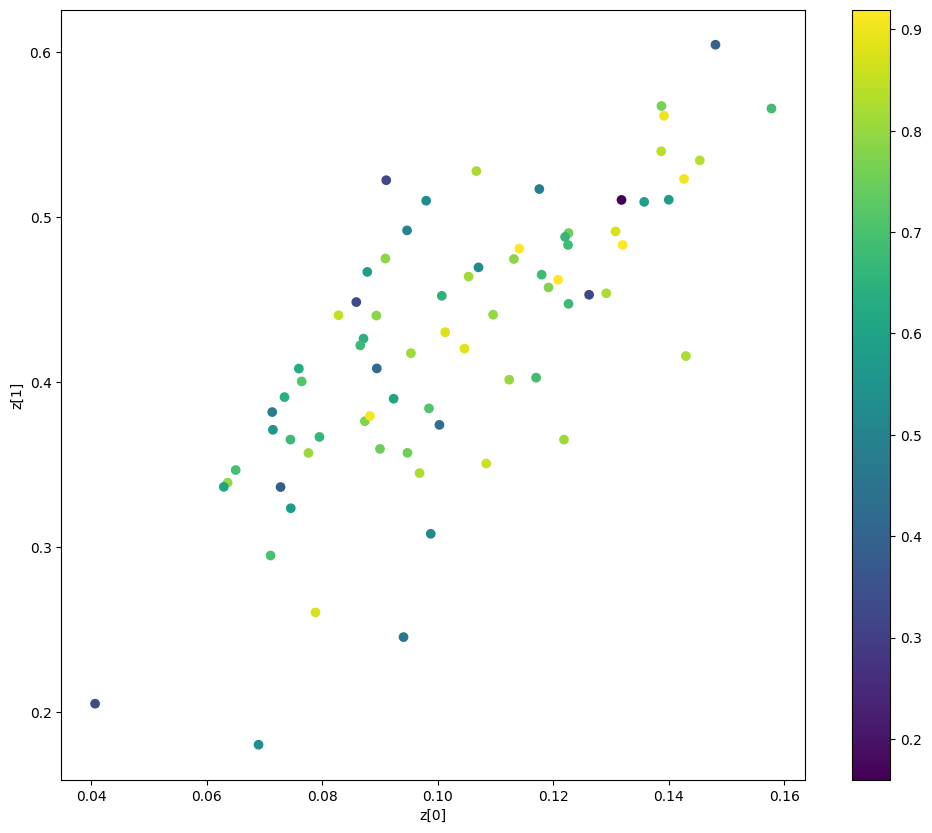

In [61]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


train_data = DataGenerator(
                            data=train_df,
                            mapping = SMILE_to_index, 
                            max_len = NUM_ATOMS,
                            batch_size=8000
                        )
x_train, y_train = next(iter(train_data))
plot_label_clusters(model, x_train, y_train)

## Conclusion
In this example, we combined model architectures from two papers,
"Automatic chemical design using a data-driven continuous representation of
molecules" from 2016 and the "MolGAN" paper from 2018. The former paper
treats SMILES inputs as strings and seeks to generate molecule strings in SMILES format,
while the later paper considers SMILES inputs as graphs (a combination of adjacency
matrices and feature matrices) and seeks to generate molecules as graphs.
This hybrid approach enables a new type of directed gradient-based search through chemical space.